## **Introduction**

An astounding 2.6 million Canadian adults aged 20 and over live with diagnosed heart disease. However, the number of new diagnoses has declined from 217,600 to 162,730. Early detection and management of conditions like high blood pressure, diabetes, chest pain, and high cholesterol can continue to significantly reduce heart disease risk and diagnoses (Canada, 2022). 

Preventative care lies at the forefront of today’s healthcare system, and I hope that this analysis can provide insights into the early detection of different types of chest pain in older patients to provide accurate diagnoses and improve overall patient care and outcomes.

### **The Question I Will Be Analyzing:**

##### **Can the type of chest pain and age predict the presence of heart disease in new patients?**

I will be taking a closer look at variables such as age, chest pain, and whether or not there is a presence of heart disease. This is a classification problem and will use knn algorithms to predict outcomes.

###### *By: Niharika Dwivedi* 

## **Methodology**

For this project, I will be using the Heart Disease dataset from the UCI Machine Learning Repository.

#### Variables:

- **Age**
- **Chest Pain Type (cp):**
  - 1: Typical angina
  - 2: Atypical angina
  - 3: Non-anginal pain
  - 4: Asymptomatic
- **Target (num):** The presence of heart disease, where 0 indicates no heart disease and 1 indicates the presence of heart disease.

#### Data Cleaning and Preprocessing:
- I handled “?” by assigning it to NA and converting variables to appropriate types. Used set.seed(123) for reproducibility and split data into 75% training and 25% testing.
  
- Summarized data by grouping the heart_train dataset by chest pain type and heart disease status, then calculated the mean age for each group. Used this summary for the third plot.
  
- I created 3 graphs:
Age distribution vs chest pain type for insights into age groups and chest pain types.
Percent of heart disease vs chest pain type to identify which chest pain types correlate with heart disease.
Average age vs chest pain type by heart disease diagnosis to show age distribution among different chest pain types and heart disease status.

#### Recipe, Specification and Cross-Validation:
- Recipe include response variable as num and predictors as cp and age
- Used 5-fold cross-validation with stratification by num to maintain the proportion of heart disease in each fold.
- Defined a k-NN model with tune() to optimize the number of neighbors (k).
  
#### Underfitting/Overfitting:
- I addressed potential underfitting and overfitting by tuning the KNN model with a range of k values, plotting accuracy estimates to identify the optimal number of neighbors.


#### Tuning and Evaluation:
- Performed grid search with a range of k-values (1 to 50) to find the optimal number of neighbors.
- Combined the recipe and model into a workflow.
- Tuned the model using tune_grid() on the cross-validation folds.
- Collected and analyzed the metrics to select the best model based on accuracy.
- Finalized the workflow with the best parameters and fitted the final model on the training data.
- Evaluated the final model on the testing set to assess its performance.


In [1]:
# Importing Libraries 

library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(RColorBrewer)
library(readr)
library(ggplot2)
library(dplyr)


Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
set.seed(123)

# Reading the dataframe and assigning column names
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart <- read.csv(url, header = FALSE, col.names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))
                  
heart

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [3]:
# Cleaning and wrangling my data into tidy format

heart[heart == "?" ] <- NA

heart_clean <- heart |>
  mutate(cp = as.numeric(cp), 
         num = as.factor(ifelse(num > 0, 1, 0)))  

heart_clean <- na.omit(heart_clean)

In [4]:
# Spliting the data into training and testing sets
set.seed(123) 

heart_split <- initial_split(heart_clean, prop = 0.75, strata = num)

heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train

my_train_data <- heart_train |>
    select(age, cp , num)

my_train_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
57,1,4,140,192,0,0,148,0,0.4,2,0.0,6.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,1
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


age,cp,num
<dbl>,<dbl>,<fct>
56,2,0
57,4,0
57,4,0
⋮,⋮,⋮
45,1,1
57,4,1
57,2,1


In [5]:
# Summarization

age_summary <- heart_train  |>
  group_by(cp, num)  |>
  summarise(mean_age = mean(age))  

age_summary

`summarise()` has grouped output by 'cp'. You can override using the `.groups`
argument.


cp,num,mean_age
<dbl>,<fct>,<dbl>
1,0,53.90909
1,1,53.20000
2,0,49.26667
⋮,⋮,⋮
3,1,57.71429
4,0,55.65517
4,1,56.25333


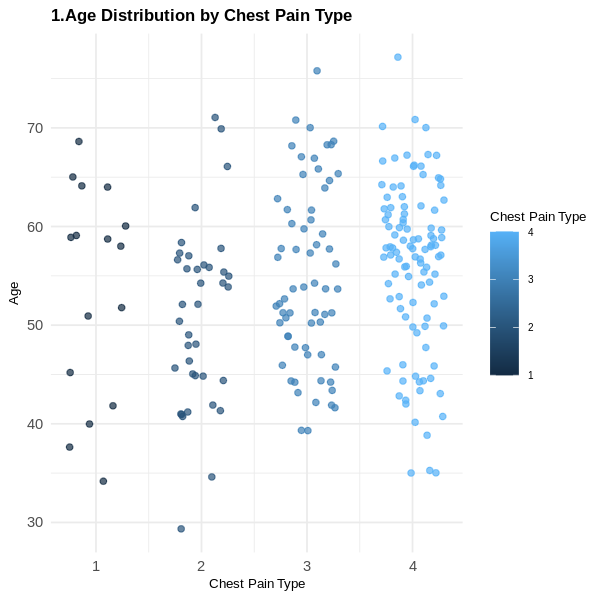

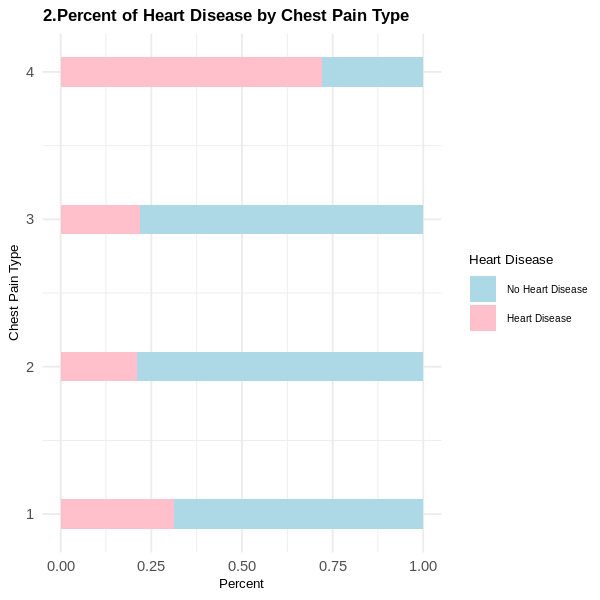

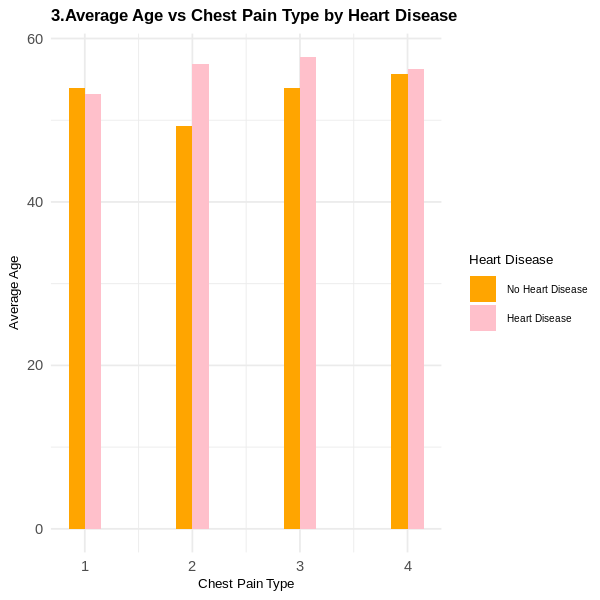

In [6]:
# Visualizing the data pre-analysis:

options(repr.plot.width = 5, repr.plot.height = 5)

# Age distribution vs chest pain type
age_cp_plot <- heart_train  |>
  ggplot(aes(x = cp, y = age, color = cp)) +
  geom_point(position = position_jitter(width = 0.3), alpha = 0.7) +
  labs(title = "1.Age Distribution by Chest Pain Type", x = "Chest Pain Type", y = "Age", color = "Chest Pain Type") +
  theme_minimal() +
  theme(plot.title = element_text(size = 10, face = "bold"),
        axis.title.x = element_text(size = 8),
        axis.title.y = element_text(size = 8),
        legend.title = element_text(size = 8),
        legend.text = element_text(size = 6))   #Changed text size for legibility in Github

age_cp_plot

# Percent of heart disease vs chest pain type
heart_cp_plot <- heart_train |>
  ggplot(aes(x = cp, fill = num)) +
  geom_bar(position = "fill", width = 0.2) +
  labs(title = "2.Percent of Heart Disease by Chest Pain Type", 
       x = "Chest Pain Type", 
       y = "Percent", 
       fill = "Heart Disease") +
  coord_flip() + 
  scale_fill_manual(values = c("lightblue", "pink"),
                    labels = c("No Heart Disease", "Heart Disease")) +
  theme_minimal() +
  theme(plot.title = element_text(size = 10, face = "bold"),
        axis.title.x = element_text(size = 8),
        axis.title.y = element_text(size = 8),
        legend.title = element_text(size = 8),
        legend.text = element_text(size = 6)) 

heart_cp_plot

# Average Age vs Chest Pain Type by Heart Disease

age_cp_heart_plot <- age_summary  |>
  ggplot(aes(x = cp, y = mean_age, fill = num)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.3) +
  labs(title = "3.Average Age vs Chest Pain Type by Heart Disease",
       x = "Chest Pain Type", y = "Average Age", fill = "Heart Disease") +
  scale_fill_manual(values = c("orange", "pink"),
                    labels = c("No Heart Disease", "Heart Disease")) +
  theme_minimal() +
  theme(plot.title = element_text(size = 10, face = "bold"),
        axis.title.x = element_text(size = 8),
        axis.title.y = element_text(size = 8),
        legend.title = element_text(size = 8),
        legend.text = element_text(size = 6)) 

age_cp_heart_plot

# Training the Model

In [23]:
# Recipe & 5 fold-cross valdiation
heart_vfold <- vfold_cv(heart_train, v = 5, strata = num) 

heart_recipe <- recipe(num ~ age + cp, data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

In [24]:
# K-nn specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 50))                          

In [25]:
# Workflow & collect metrics
knn_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6486869,5,0.04392157,Preprocessor1_Model01
1,roc_auc,binary,0.6404762,5,0.04261215,Preprocessor1_Model01
2,accuracy,binary,0.6305051,5,0.03797315,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,roc_auc,binary,0.7469048,5,0.03983826,Preprocessor1_Model49
50,accuracy,binary,0.7028283,5,0.02646995,Preprocessor1_Model50
50,roc_auc,binary,0.7456944,5,0.03623188,Preprocessor1_Model50


In [26]:
# Filter for accuracy
accuracies <- knn_results |>
    filter(.metric == "accuracy")
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6486869,5,0.04392157,Preprocessor1_Model01
2,accuracy,binary,0.6305051,5,0.03797315,Preprocessor1_Model02
3,accuracy,binary,0.5896970,5,0.02938448,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,binary,0.6983838,5,0.02845788,Preprocessor1_Model48
49,accuracy,binary,0.6982828,5,0.02478126,Preprocessor1_Model49
50,accuracy,binary,0.7028283,5,0.02646995,Preprocessor1_Model50


In [27]:
# Choosing best K

best_k <- accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
best_k 

[1] 17

# Underfitting/ Overfitting 

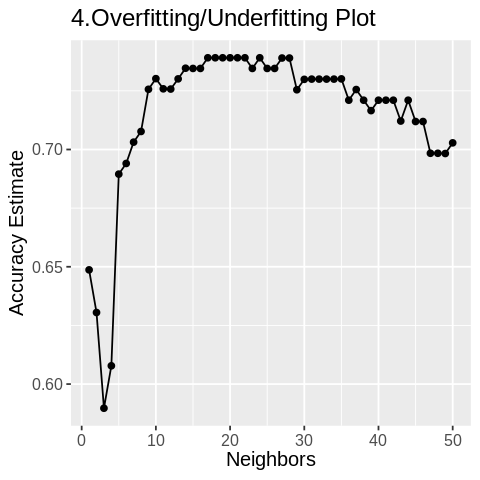

In [28]:
k_lots <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_lots) |>
  collect_metrics()

accuracies_klots <- knn_results_fit |>
  filter(.metric == "accuracy")

options(repr.plot.width = 4, repr.plot.height = 4)

accuracy_vs_k_lots <- ggplot(accuracies_klots, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "4.Overfitting/Underfitting Plot", x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k_lots

# Evaluating on Test Set

In [29]:
# Recipe, specification and workflow

heart_recipe_new <- recipe(num ~ age + cp, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec_new <- nearest_neighbor(weight_func= "rectangular", neighbor = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit_new <- workflow() |>
  add_recipe(heart_recipe_new) |>
  add_model(knn_spec_new ) |>
  fit(data = heart_train)

knn_fit_new


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(17L,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2657658
Best kernel: rectangular
Best k: 17

In [30]:
# Predicting and assessing accuracy 

heart_test_predictions <- predict(knn_fit_new, heart_test) |>
  bind_cols(heart_test)

heart_test_predictions |>
  metrics(truth = num, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.76


In [31]:
# Calculating precision
heart_test_predictions |>
    precision(truth = num, estimate = .pred_class, event_level="first")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8055556


In [32]:
# Calculating recall
heart_test_predictions |>
    recall(truth = num, estimate = .pred_class, event_level="first")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.725


In [33]:
# Confusion Matrix
confusion <- heart_test_predictions |>
             conf_mat(truth = num, estimate = .pred_class)
confusion

          Truth
Prediction  0  1
         0 29  7
         1 11 28

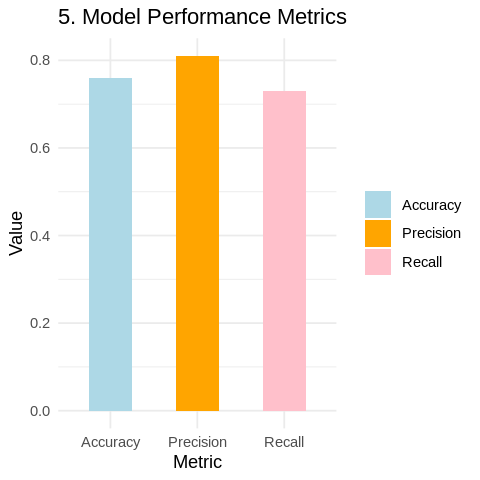

In [34]:
metrics_df <- tibble(
  Metric = c("Accuracy", "Precision", "Recall"),
  Value = c(0.76, 0.81, 0.73)
)

accuracy_plot <- ggplot(metrics_df, aes(x = Metric, y = Value, fill = Metric)) +
  geom_bar(stat = "identity", width = 0.5) +
  labs(title = "5. Model Performance Metrics",
       y = "Value",
       fill = NULL) +
  scale_fill_manual(values = c("Accuracy" = "light blue", "Precision" = "orange", "Recall" = "pink")) + 
  theme_minimal()

accuracy_plot


# Discussion

1. Summary of my findings:
   - 0 = No presence of Heart disease
   - 1 = Presence of Heart disease
   - The model performed with an accuracy of 76%, precision of 80.55% and recall of 72.5%


2. Interpretation of my findings:

   - 76% accuracy seems like a moderate measurement, however, it's important to note that accuracy alone doesn't tell the whole story
   - With 80% precision, the model is reasonably good at identifying true cases of heart disease among all predicted positive cases. This means that 80% of the patients predicted to have heart disease actually have it, minimizing unnecessary treatments for patients who do not have the condition.
   - The recall of 72% indicates that the model is successful in identifying 72% of all actual heart disease cases. This is critical because missing a patient with heart disease (false negative) could have serious health consequences.
   - Healthcare providers may use such a model as an initial screening tool to prioritize patients for further diagnostic tests. A higher recall would ensure fewer cases of heart disease are missed, potentially leading to earlier treatment and better patient outcomes.

   
3. Is this what you expected to find?

    - Yes, this is what I expected to find. After doing research online, chest pain and age are some of the key predictors of heart disease. My model is consistent with my initial research and can further help doctors use this as an initial screening tool to aid diagnosis and treatment plans. 

## **Impact and Future Questions**

Expected outcomes include finding that chest pain types non-anginal pain and asymptomatic (3 and 4) and older ages are linked to higher heart disease risk. As mentioned above, using this model underscores the importance of preventative care and the early detection of risk factors like chest pain and age, which can reduce the burden of heart disease in the population and healthcare system. 

Future questions:
-  What is the impact of other variables like gender(sex) or lifestyle (smoking or no smoking) on heart disease risk and prevention?
-  How generalizable are these findings to diverse patient populations and healthcare settings?
-  How can I improve the accuracy, precision or recall to make doctors more confident in using my model for initial screening plans?



## **References**

Canada, P. H. A. of. (2022, July 28). Government of Canada. Canada.ca. https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html

Detrano, R., Janosi, A., Steinbrunn, W., & Pfisterer, M. (1988). Heart disease. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/45/heart+disease 

Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988). Heart disease. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/45/heart+disease 

Timbers, T., Campbell, T., & Lee, M. (2023, December 23). Data science. Data Science. https://datasciencebook.ca/ 


## **Closing note**

This project report was done for DSCI 100 003 supervised by Dr. Vivian Meng at Univeristy of British Columbia. A lot of inspiration for this project is taken from the textbook, lecture slides and help from TAs.

I also enjoy blogging and put this project together as a medium post. Here is the link: https://medium.com/@dwninii/k-nn-classification-to-diagnose-heart-disease-in-patients-2fe4a20ea0cf.

*Document Word count: 915*
